In [1]:
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# The Data

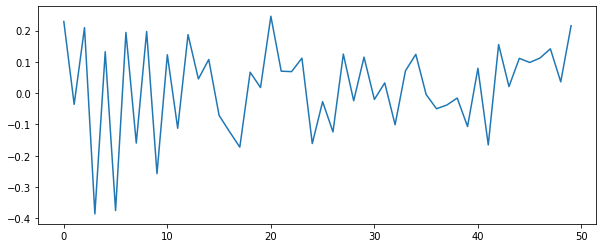

In [2]:
true_phi_1 = -0.2
true_phi_2 = 0.5
true_sigma = 0.1

xvals = [np.random.normal(0, true_sigma), np.random.normal(0, true_sigma)]
for _ in range(50):
    xvals.append(
        true_phi_1 * xvals[-1]
        + true_phi_2 * xvals[-2]
        + np.random.normal(0, true_sigma)
    )
xvals = np.array(xvals[2:])
plt.figure(figsize=(10, 4))
plt.plot(xvals)

# Usual Method : Fit AR Model

In [3]:
model = ARIMA(xvals, order=(2, 0, 0)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   50
Model:                 ARIMA(2, 0, 0)   Log Likelihood                  38.656
Date:                Tue, 01 Nov 2022   AIC                            -69.312
Time:                        00:42:49   BIC                            -61.664
Sample:                             0   HQIC                           -66.399
                                 - 50                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0221      0.027      0.807      0.419      -0.032       0.076
ar.L1         -0.1878      0.146     -1.283      0.199      -0.475       0.099
ar.L2          0.5464      0.136      4.028      0.000       0.280       0.812
sigma2         0.0123      0.003      4.378      0.000       0.007       0.018
===================================================================================
Ljung-Box (L1) (Q):                   2.93   Jarque-Bera (JB):                 3.65
Prob(Q):                              0.09   Prob(JB):                         0.16
Heteroskedasticity (H):               0.49   Skew:                            -0.65
Prob(H) (two-sided):                  0.15   Kurtosis:                         3.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

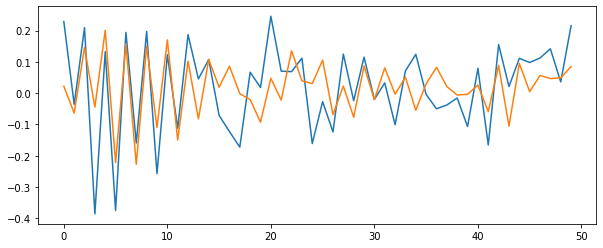

In [4]:
plt.figure(figsize=(10, 4))
plt.plot(xvals)
plt.plot(model.fittedvalues)

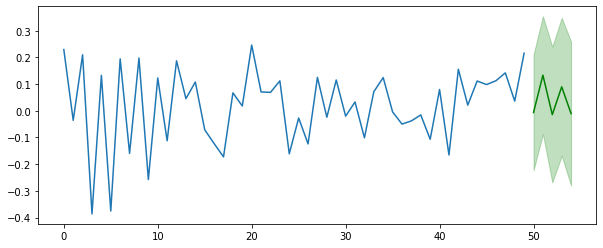

In [5]:
plt.figure(figsize=(10, 4))
plt.plot(xvals)

prediction_info = model.get_forecast(5).summary_frame(alpha=0.05)

predictions = prediction_info["mean"].values
lower_bound = prediction_info["mean_ci_lower"].values
upper_bound = prediction_info["mean_ci_upper"].values


plt.plot(range(len(xvals), len(xvals) + 5), predictions, color="g")
plt.fill_between(
    range(len(xvals), len(xvals) + 5),
    lower_bound,
    upper_bound,
    color="g",
    alpha=0.25,
)

In [15]:
prediction_info

y,mean,mean_se,mean_ci_lower,mean_ci_upper
0,-0.006629,0.110684,-0.223566,0.210308
1,0.133290,0.112620,-0.087441,0.354021
2,-0.014501,0.129722,-0.268752,0.239750
3,0.089707,0.131825,-0.168665,0.348080
4,-0.010614,0.137639,-0.280381,0.259153


# Bayesian Analysis with PyMC3
***

# Priors:
## $\phi_1 \sim N(0,20)$
## $\phi_2 \sim N(0,20)$
## $\sigma \sim Exp(1)$
***

# Likelihood:
## $x_t|\phi_1, \phi_2, \sigma, x_{t-1}, x_{t-2} \sim N(\phi_1 x_{t-1} + \phi_2 x_{t-2}, \sigma)$
***

# Posterior
## $\phi_1, \phi_2, \sigma|x \sim ?$
***

/home/masoud/anaconda3/envs/coding_env/lib/python3.7/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, phi]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3 seconds.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/home/masoud/anaconda3/envs/coding_env/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  del sys.path[0]
Got error No model on context stack. trying to find log_likelihood in translation.
/home/masoud/anaconda3/envs/coding_env/lib/python3.7/site-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
Got error No model on context stack. trying to find log_likelihood in translation.


<Figure size 504x504 with 0 Axes>

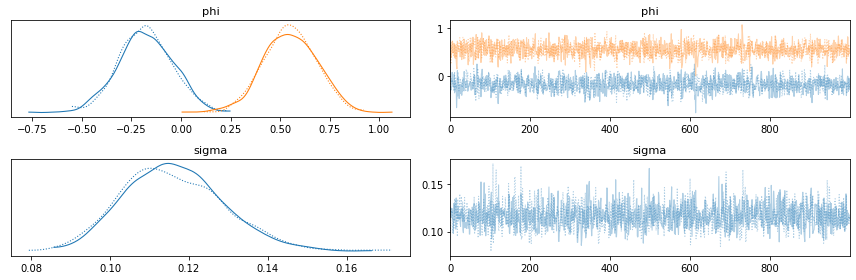

In [6]:
with pm.Model() as bayes_model:
    # priors
    phi = pm.Normal("phi", mu=0, sigma=20, shape=2)
    sigma = pm.Exponential("sigma", lam=1)

    # Likelihood
    likelihood = pm.AR("x", phi, sigma, observed=xvals)

    # sample from the posterior distribution
    trace = pm.sample(1000, cores=2)

plt.figure(figsize=(7, 7))
pm.traceplot(trace)
plt.tight_layout()

# Parameter Distributions

<Figure size 720x288 with 0 Axes>

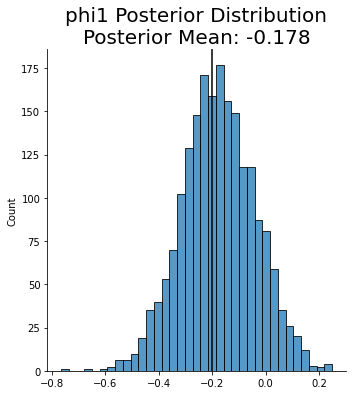

<Figure size 720x288 with 0 Axes>

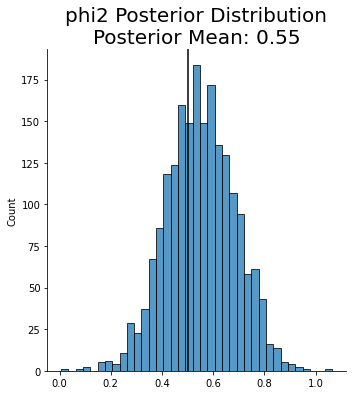

<Figure size 720x288 with 0 Axes>

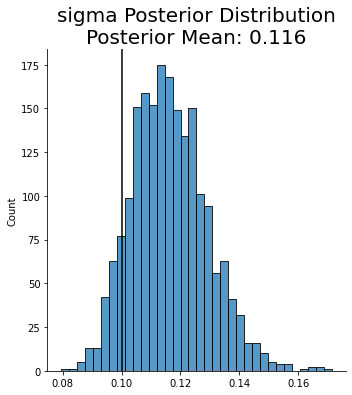

In [7]:
phi1_vals = trace.get_values("phi")[:, 0]
phi2_vals = trace.get_values("phi")[:, 1]
sigma_vals = trace.get_values("sigma")

plt.figure(figsize=(10, 4))
sns.displot(phi1_vals)
plt.axvline(true_phi_1, color="k")
plt.title(
    "phi1 Posterior Distribution\nPosterior Mean: %s" % round(phi1_vals.mean(), 3),
    fontsize=20,
)
plt.show()

plt.figure(figsize=(10, 4))
sns.displot(phi2_vals)
plt.axvline(true_phi_2, color="k")
plt.title(
    "phi2 Posterior Distribution\nPosterior Mean: %s" % round(phi2_vals.mean(), 3),
    fontsize=20,
)
plt.show()

plt.figure(figsize=(10, 4))
sns.displot(sigma_vals)
plt.axvline(true_sigma, color="k")
plt.title(
    "sigma Posterior Distribution\nPosterior Mean: %s" % round(sigma_vals.mean(), 3),
    fontsize=20,
)
plt.show()

# Forecast Next Values

In [8]:
num_samples = 10000
forecasted_vals = []
num_periods = 5

for _ in range(num_samples):
    curr_vals = list(xvals.copy())

    phi1_val = np.random.choice(phi1_vals)
    phi2_val = np.random.choice(phi2_vals)
    sigma_val = np.random.choice(sigma_vals)

    for _ in range(num_periods):
        curr_vals.append(
            curr_vals[-1] * phi1_val
            + curr_vals[-2] * phi2_val
            + np.random.normal(0, sigma_val)
        )
    forecasted_vals.append(curr_vals[-num_periods:])
forecasted_vals = np.array(forecasted_vals)

In [10]:
vals

array([-0.02375994,  0.0343524 , -0.00124993, ..., -0.35155558,
       -0.00485784, -0.04007987])

<Figure size 720x288 with 0 Axes>

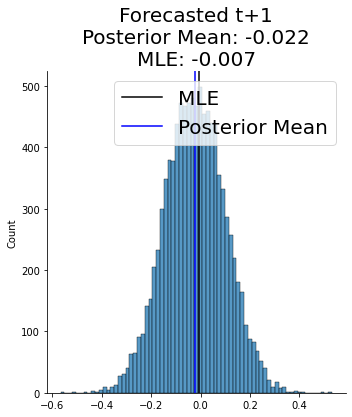

<Figure size 720x288 with 0 Axes>

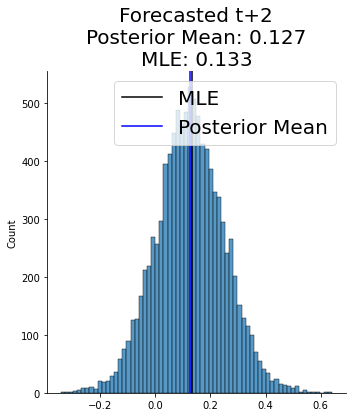

<Figure size 720x288 with 0 Axes>

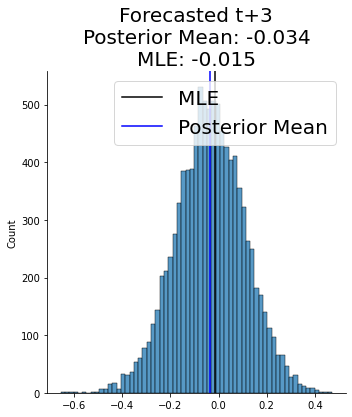

<Figure size 720x288 with 0 Axes>

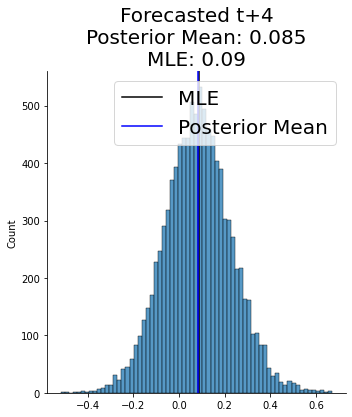

<Figure size 720x288 with 0 Axes>

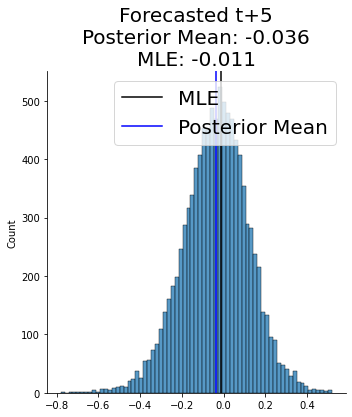

In [16]:
for i in range(num_periods):
    plt.figure(figsize=(10, 4))
    vals = forecasted_vals[:, i]
    mu, dev = round(vals.mean(), 3), round(vals.std(), 3)
    sns.displot(vals)
    p1 = plt.axvline(predictions[i], color="k")
    p2 = plt.axvline(vals.mean(), color="b")
    plt.legend((p1, p2), ("MLE", "Posterior Mean"), fontsize=20)
    plt.title(
        "Forecasted t+%s\nPosterior Mean: %s\nMLE: %s"
        % ((i + 1), mu, round(predictions[i], 3)),
        fontsize=20,
    )